In [6]:
# Paso 1: Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

# Paso 2: Cargar los archivos CSV
countries_df = pd.read_csv(r'C:\Users\serghi.arista\Documents\GitHub\Diplomado_PUCP\_data\countries.csv')
ab_data_df = pd.read_csv(r'C:\Users\serghi.arista\Documents\GitHub\Diplomado_PUCP\_data\ab_data.csv')

# Paso 3: Realizar el merge de los DataFrames en base a "user_id"
merged_df = pd.merge(ab_data_df, countries_df, on='user_id', how='inner')

merged_df

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US
...,...,...,...,...,...,...
294477,945152,51:57.1,control,old_page,0,US
294478,734608,45:03.4,control,old_page,0,US
294479,697314,20:29.0,control,old_page,0,US
294480,715931,40:24.5,treatment,new_page,0,UK


In [8]:
# Paso 1: Definir las condiciones
condition_treatment_new_page = (merged_df['group'] == 'treatment') & (merged_df['landing_page'] == 'new_page')
condition_control_old_page = (merged_df['group'] == 'control') & (merged_df['landing_page'] == 'old_page')

# Paso 2: Aplicar las condiciones
filtered_df = merged_df[condition_treatment_new_page | condition_control_old_page]

filtered_df

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US
...,...,...,...,...,...,...
294477,945152,51:57.1,control,old_page,0,US
294478,734608,45:03.4,control,old_page,0,US
294479,697314,20:29.0,control,old_page,0,US
294480,715931,40:24.5,treatment,new_page,0,UK


0    11:48.6
1    01:45.2
2    55:06.2
3    28:03.1
4    52:26.2
Name: timestamp, dtype: object
Formato de timestamp inconsistente. Procediendo con limpieza de datos.


C:\Users\serghi.arista\AppData\Local\Temp\ipykernel_22680\345986836.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], errors='coerce')
C:\Users\serghi.arista\AppData\Local\Temp\ipykernel_22680\345986836.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], errors='coerce')
C:\Users\serghi.arista\AppData\Local\Temp\ipykernel_22680\345986836.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

174897


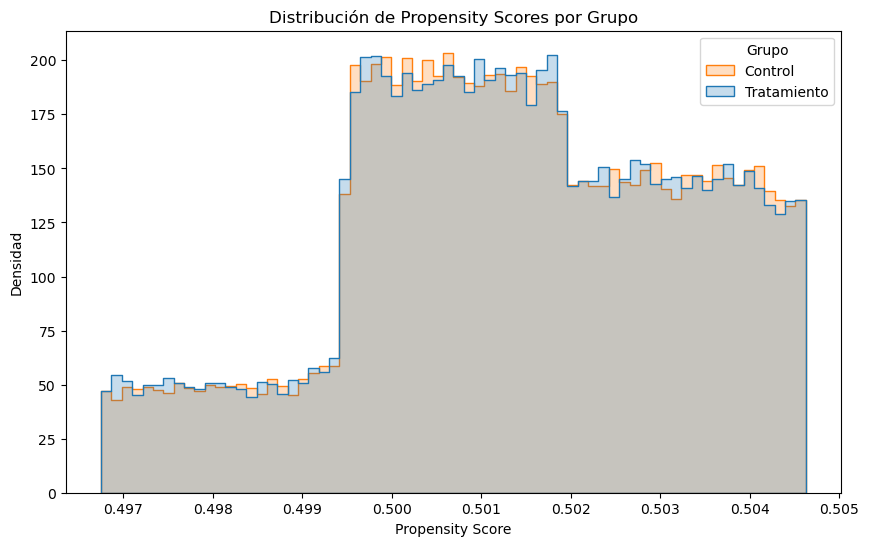

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Verificar el formato del timestamp
print(filtered_df['timestamp'].head())

# Intentar convertir a datetime con un formato específico
try:
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], format='%H:%M:%S.%f')
except ValueError:
    print("Formato de timestamp inconsistente. Procediendo con limpieza de datos.")

# Alternativamente, tratar de parsear timestamps automáticamente y manejar errores
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], errors='coerce')

# Verificar si hay valores NaT (Not a Time) que indican fallos en la conversión
print(filtered_df['timestamp'].isna().sum())

# Remover filas con valores NaT en timestamp si hay errores
filtered_df = filtered_df.dropna(subset=['timestamp'])

# Convertir timestamp a minutos
filtered_df['timestamp_minutes'] = (filtered_df['timestamp'] - filtered_df['timestamp'].min()).dt.total_seconds() / 60

# Paso 2: Codificar variables categóricas
country_dummies = pd.get_dummies(filtered_df['country'], drop_first=True)
filtered_df = pd.concat([filtered_df, country_dummies], axis=1)
X = filtered_df[['timestamp_minutes'] + list(country_dummies.columns)]
y = (filtered_df['group'] == 'treatment').astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Calcular propensity scores
log_model = LogisticRegression()
log_model.fit(X_scaled, y)
filtered_df['propensity_score'] = log_model.predict_proba(X_scaled)[:, 1]

# Paso 4: Visualizar los propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_df, x='propensity_score', hue='group', element='step', stat='density', common_norm=False)
plt.title('Distribución de Propensity Scores por Grupo')
plt.xlabel('Propensity Score')
plt.ylabel('Densidad')
plt.legend(title='Grupo', labels=['Control', 'Tratamiento'])
plt.show()
